In [1]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES']='7'
import tensorflow as tf
import mobilenet_lib
from matplotlib import pyplot
import numpy as np

import shutil
from caffe2.proto import caffe2_pb2
from six import text_type
import skimage.io
import skimage.transform
from matplotlib import pyplot
import urllib2

from caffe2.python import core, model_helper, workspace, brew, net_drawer, visualize, utils
import caffe2.python.predictor.predictor_exporter as pe
core.GlobalInit(["caffe2", "--caffe2-log-level=1"])

print("core.GlobalInit for what?")

core.GlobalInit for what?


In [2]:
# Configuration --- Change to your setup and preferences!
# CAFFE_MODELS = "/usr/local/caffe2/python/models"
CAFFE_MODELS = "/home/zhanglinghan/caffe2/build/caffe2/python/models"

# sample images you can try, or use any URL to a regular image.
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Whole-Lemon.jpg/1235px-Whole-Lemon.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/7/7b/Orange-Whole-%26-Split.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/a/ac/Pretzel.jpg"
IMAGE_LOCATION = "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg"
# IMAGE_LOCATION = "images/cat.jpg"
# IMAGE_LOCATION = "images/cowboy-hat.jpg"
# IMAGE_LOCATION = "images/cell-tower.jpg"
# IMAGE_LOCATION = "images/Ducreux.jpg"
# IMAGE_LOCATION = "images/pretzel.jpg"
# IMAGE_LOCATION = "images/orangutan.jpg"
# IMAGE_LOCATION = "images/aircraft-carrier.jpg"
# IMAGE_LOCATION = "images/cat.jpg"

# What model are we using? You should have already converted or downloaded one.
# format below is the model's: 
# folder, INIT_NET, predict_net, mean, input image size
# you can switch squeezenet out with 'bvlc_alexnet', 'bvlc_googlenet' or others that you have downloaded
# if you have a mean file, place it in the same dir as the model
MODEL = 'squeezenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 160

# codes - these help decypher the output and source from a list from AlexNet's object codes to provide an result like "tabby cat" or "lemon" depending on what's in the picture you submit to the neural network.
# The list of output codes for the AlexNet models (squeezenet)
codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"
print "Config set!"

Config set!


Functions set.
mean was set to:  128
INIT_NET =  /home/zhanglinghan/caffe2/build/caffe2/python/models/squeezenet/init_net.pb
PREDICT_NET =  /home/zhanglinghan/caffe2/build/caffe2/python/models/squeezenet/predict_net.pb
Found  /home/zhanglinghan/caffe2/build/caffe2/python/models/squeezenet/init_net.pb ...Now looking for /home/zhanglinghan/caffe2/build/caffe2/python/models/squeezenet/predict_net.pb
All needed files found! Loading the model in the next block.
Original image shape:(751, 1280, 3) and remember it should be in H, W, C!
Model's input shape is 160x160
Orginal aspect ratio: 1.70439414115
New image shape:(160, 272, 3) in HWC
After crop:  (160, 160, 3)
NCHW:  (1, 3, 160, 160)
NHWC:  (1, 160, 160, 3)


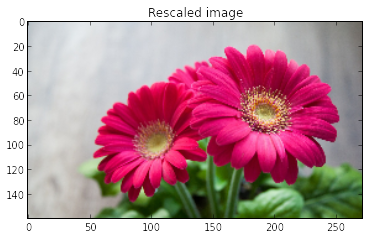

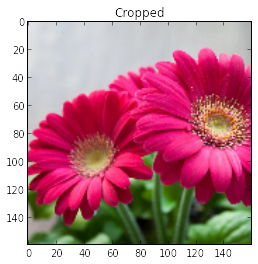

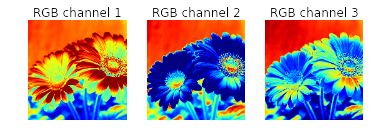

In [3]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def rescale(img, input_height, input_width):
    print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
    print("Model's input shape is %dx%d") % (input_height, input_width)
    aspect = img.shape[1]/float(img.shape[0])
    print("Orginal aspect ratio: " + str(aspect))
    if(aspect>1):
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if(aspect == 1):
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    pyplot.figure()
    pyplot.imshow(imgScaled)
    pyplot.axis('on')
    pyplot.title('Rescaled image')
    print("New image shape:" + str(imgScaled.shape) + " in HWC")
    return imgScaled
print "Functions set."

# set paths and variables from model choice and prep image
CAFFE_MODELS = os.path.expanduser(CAFFE_MODELS)

# mean can be 128 or custom based on the model
# gives better results to remove the colors found in all of the training images
MEAN_FILE = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    mean = 128
else:
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print "mean was set to: ", mean

# some models were trained with different image sizes, this helps you calibrate your image
INPUT_IMAGE_SIZE = MODEL[4]

# make sure all of the files are around...
#if not os.path.exists(CAFFE2_ROOT):
#    print("Houston, you may have a problem.") 
INIT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[1])
print 'INIT_NET = ', INIT_NET
PREDICT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[2])
print 'PREDICT_NET = ', PREDICT_NET
if not os.path.exists(INIT_NET):
    print(INIT_NET + " not found!")
else:
    print "Found ", INIT_NET, "...Now looking for", PREDICT_NET
    if not os.path.exists(PREDICT_NET):
        print "Caffe model file, " + PREDICT_NET + " was not found!"
    else:
        print "All needed files found! Loading the model in the next block."
        
# load and transform image
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print "After crop: " , img.shape
pyplot.figure()
pyplot.imshow(img)
pyplot.axis('on')
pyplot.title('Cropped')

# switch to CHW
img = img.swapaxes(1, 2).swapaxes(0, 1)
pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

# switch to BGR
img = img[(2, 1, 0), :, :]
img_tf = img[:, :, :]

# # remove mean for better results
img = (img * 255 - mean) / 255
img_tf = (img_tf * 255 - mean) / 255

# add batch size
img = img[np.newaxis, :, :, :].astype(np.float32)
print "NCHW: ", img.shape

# add batch size
img_tf = img_tf[np.newaxis, :, :, :].astype(np.float32)
img_tf = img_tf.swapaxes(1, 2).swapaxes(2, 3)
print "NHWC: ", img_tf.shape

In [4]:
init_net_serial = None
predict_net_serial = None
with open("convert_mobilenet_model_from_tensorflow_to_caffe2_init_net.pb", "r") as file_in:
    init_net_serial = file_in.read()
with open("convert_mobilenet_model_from_tensorflow_to_caffe2_predict_net.pb", "r") as file_in:
    predict_net_serial = file_in.read()

init_net = caffe2_pb2.NetDef()
init_net.ParseFromString(init_net_serial)
predict_net = caffe2_pb2.NetDef()
predict_net.ParseFromString(predict_net_serial)

from IPython import display
graph = net_drawer.GetPydotGraph(predict_net.op[:50], "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

workspace.ResetWorkspace()

workspace.RunNetOnce(init_net)
workspace.FeedBlob("data", img)
workspace.CreateNet(predict_net, True)
workspace.RunNet(predict_net.name)

True

In [5]:
graph = tf.Graph()
sess = tf.Session(graph=graph)

with graph.as_default():
    mobilenet_func = mobilenet_lib.mobilenet_factory(depth_multiplier=0.5, default_image_size=160, scope="MobilenetV1")
    input_data = tf.placeholder(tf.float32, shape=(1, 160, 160, 3))
    logit, end_points = mobilenet_func(input_data, 3, False)
    
    saver = tf.train.Saver()
    saver.restore(sess, "/world/data-c22/AR/damo_porn_weighting_4/model.ckpt")

    for i in range(1, 14):
        
        print "After pointwise %d:" %(i)
        tensor_pw_relu = tf.get_default_graph().get_tensor_by_name("MobilenetV1/MobilenetV1/Conv2d_%d_pointwise/Relu:0" %(i))
        tensor = sess.run([tensor_pw_relu], feed_dict={input_data: img_tf})
        
        print "tf %d:" %(i)
        print tensor[0].shape
        print tensor[0][0, 0:5, 0:5, 8]
        
        tensor_c2 = workspace.FetchBlob("pointwise%d_relu" %(i))
        print "c2 %d:" %(i)
        print tensor_c2.shape
        print tensor_c2[0, 8, 0:5, 0:5]
        
        print "---------------------------------"
    
    print "After average pooling:"
    tensor_ap = tf.get_default_graph().get_tensor_by_name("MobilenetV1/Logits/AvgPool_1a/AvgPool:0")
    tensor_ap = sess.run([tensor_ap], feed_dict={input_data: img_tf})
    print "tf :"
    print tensor_ap[0].shape
    print tensor_ap[0][0, 0, 0, 0:100]
    
    tensor_c2 = workspace.FetchBlob("average_pool")
    print tensor_c2.shape
    print tensor_c2[0, 0:100, 0, 0]
    
    for i in range(tensor_c2.shape[1]):
        if tensor_ap[0][0, :, :, i] - tensor_c2[0, i, :, :] > 1e-6:
            print tensor_ap[0][0, :, :, i], tensor_c2[0, i, :, :], i

    print "---------------------------------"
    print "After final convolution:"
    tensor_fc = tf.get_default_graph().get_tensor_by_name("MobilenetV1/Logits/Conv2d_1c_1x1/BiasAdd:0")
    tensor_fc = sess.run([tensor_fc], feed_dict={input_data: img_tf})
    print "tf :"
    print tensor_fc[0].shape
    print tensor_fc[0]
    
    print "c2 :"
    tensor_c2 = workspace.FetchBlob("conv_final")
    print tensor_c2.shape
    print tensor_c2
    
    print "---------------------------------"
    print "After softmax:"
    tensor_sm = tf.get_default_graph().get_tensor_by_name("MobilenetV1/Predictions/Softmax:0")
    tensor_sm = sess.run([tensor_sm], feed_dict={input_data: img_tf})
    print "tf :"
    print tensor_sm[0].shape
    print tensor_sm[0]
    
    print "c2 :"
    tensor_c2 = workspace.FetchBlob("softmax")
    print tensor_c2.shape
    print tensor_c2

After pointwise 1:
tf 1:
(1, 80, 80, 32)
[[ 1.01663113  1.02551532  1.00166965  1.03784776  1.07363153]
 [ 0.          0.          0.12285566  0.05001974  0.04035044]
 [ 0.          0.          0.1250205   0.09392595  0.02615499]
 [ 0.          0.12120771  0.          0.          0.00990963]
 [ 0.          0.          0.12861776  0.17265129  0.        ]]
c2 1:
(1, 32, 80, 80)
[[ 1.0166316   1.02551508  1.00167012  1.03784776  1.07363105]
 [ 0.          0.          0.12285566  0.05002022  0.04035044]
 [ 0.          0.          0.12502003  0.09392548  0.02615547]
 [ 0.          0.12120771  0.          0.          0.00991011]
 [ 0.          0.          0.12861776  0.17265081  0.        ]]
---------------------------------
After pointwise 2:
tf 2:
(1, 40, 40, 64)
[[ 1.24274898  0.95580745  1.14867187  1.02256799  0.92312026]
 [ 0.81705451  0.67933464  0.86892247  0.7890718   0.59852552]
 [ 0.853544    0.69443011  0.51698005  0.46030176  0.50871897]
 [ 0.91437101  0.67635131  0.65879917  0.

In [6]:
workspace.ResetWorkspace()
p = workspace.Predictor(init_net_serial, predict_net_serial)
results = p.run([img])
print results

[array([[[[ 0.03251991]],

        [[ 0.04927812]],

        [[ 0.91820198]]]], dtype=float32)]


In [7]:
# # get all node name
# with graph.as_default():
#     nodes_lst = [n.name for n in tf.get_default_graph().as_graph_def().node]
#     for i in nodes_lst:
#         print i